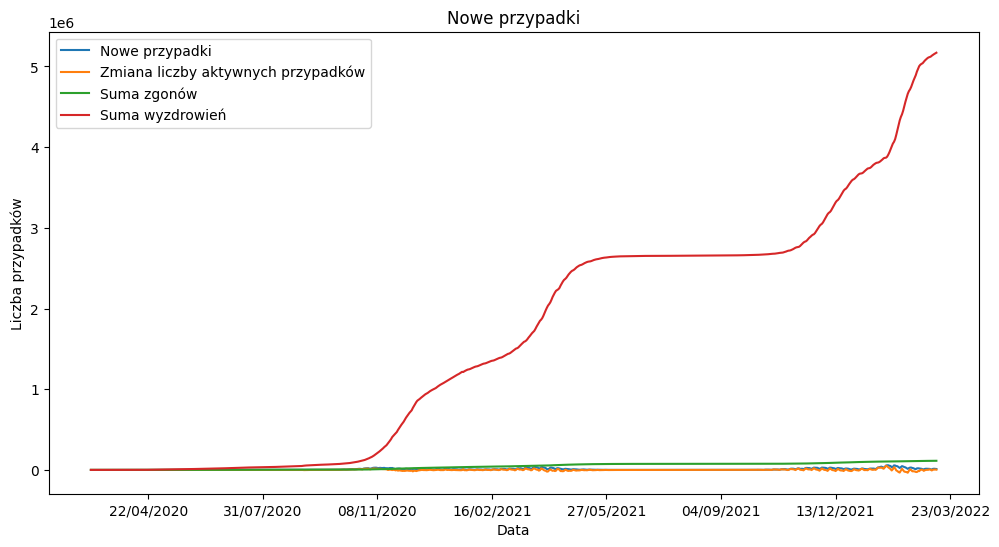

In [70]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.nn as nn
import torch.optim as optim
import math

# Load the dataset
df = pd.read_csv('DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=["Data", "Nowe przypadki", "Zmiana liczby aktywnych przypadków", 'Suma zgonów', 'Suma wyzdrowień'])
df = df.dropna()

# Convert date strings to datetime objects
def convert_to_datetime_with_year_increment(date_series, start_year):
    previous_month = 0
    current_year = start_year
    datetime_list = []

    for date in date_series:
        current_month = int(date.split('/')[1])
        if current_month == 1 and previous_month == 12:
            current_year += 1
        date_with_year_str = date + f'/{current_year}'
        datetime_obj = datetime.strptime(date_with_year_str, '%d/%m/%Y')
        datetime_list.append(datetime_obj)

        previous_month = current_month

    return datetime_list

df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '').astype(int)
df['Suma zgonów'] = df['Suma zgonów'].astype(int)
df['Suma wyzdrowień'] = df['Suma wyzdrowień'].astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '').astype(int)
df['Data'] = df['Data'].apply(lambda x: "{:04.2f}".format(x).replace('.', '/'))
df['Data'] = convert_to_datetime_with_year_increment(df['Data'], 2020)

# Visualize the data
def visualise(df):
    plt.figure(figsize=(12, 6))
    plt.title('Nowe przypadki')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.plot(df['Data'], df['Suma zgonów'], label='Suma zgonów')
    plt.plot(df['Data'], df['Suma wyzdrowień'], label='Suma wyzdrowień')
    plt.xlabel('Data')
    plt.ylabel('Liczba przypadków')
    plt.legend()
    plt.show()

visualise(df)

# Scaling the data
scaler = MinMaxScaler()
df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Suma zgonów', 'Suma wyzdrowień']] = scaler.fit_transform(df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Suma zgonów', 'Suma wyzdrowień']])

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df = df[:split_idx]
test_df = df[split_idx:]

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Example sequence length
train_data = train_df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Suma zgonów', 'Suma wyzdrowień']].values
test_data = test_df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Suma zgonów', 'Suma wyzdrowień']].values

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [72]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(num_features, d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

        self.linear = nn.Linear(d_model, num_features)
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def positional_encoding(self, seq_len, d_model):
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(1)  # Add batch dimension

    def forward(self, src, tgt):
        src = self.embedding(src)  # Apply embedding layer
        tgt = self.embedding(tgt)  # Apply embedding layer
        src = src.permute(1, 0, 2)  # Transformer expects seq_len, batch_size, num_features
        tgt = tgt.permute(1, 0, 2)

        src_pe = self.positional_encoding(src.size(0), src.size(2)).to(src.device)
        tgt_pe = self.positional_encoding(tgt.size(0), tgt.size(2)).to(tgt.device)

        src = src + src_pe
        tgt = tgt + tgt_pe

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.linear(output)
        return output.permute(1, 0, 2)

# Model parameters
num_features = 4
seq_length = 30  # Set the sequence length here
d_model = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
dropout = 0.1

model = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)


In [73]:
# Training parameters
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


# Training loop with test loss calculation
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()

        # Transformer needs a target sequence as well, we'll use a shifted version of the input
        y_input = torch.zeros_like(x_batch)
        y_input[:, 1:, :] = x_batch[:, :-1, :]
        y_input[:, 0, :] = x_batch[:, 0, :]  # First element as it is

        output = model(x_batch, y_input)
        loss = criterion(output[:, -1, :], y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * x_batch.size(0)

    train_loss = running_train_loss / len(train_dataloader.dataset)

    # Calculate test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            x_batch, y_batch = batch

            y_input = torch.zeros_like(x_batch)
            y_input[:, 1:, :] = x_batch[:, :-1, :]
            y_input[:, 0, :] = x_batch[:, 0, :]

            output = model(x_batch, y_input)
            loss = criterion(output[:, -1, :], y_batch)

            running_test_loss += loss.item() * x_batch.size(0)

    test_loss = running_test_loss / len(test_dataloader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/20, Train Loss: 0.0682, Test Loss: 0.0440
Epoch 2/20, Train Loss: 0.0215, Test Loss: 0.0408
Epoch 3/20, Train Loss: 0.0129, Test Loss: 0.0587
Epoch 4/20, Train Loss: 0.0097, Test Loss: 0.0514
Epoch 5/20, Train Loss: 0.0084, Test Loss: 0.0391
Epoch 6/20, Train Loss: 0.0073, Test Loss: 0.0378
Epoch 7/20, Train Loss: 0.0063, Test Loss: 0.0424
Epoch 8/20, Train Loss: 0.0057, Test Loss: 0.0410
Epoch 9/20, Train Loss: 0.0050, Test Loss: 0.0361
Epoch 10/20, Train Loss: 0.0047, Test Loss: 0.0336
Epoch 11/20, Train Loss: 0.0041, Test Loss: 0.0366
Epoch 12/20, Train Loss: 0.0040, Test Loss: 0.0363
Epoch 13/20, Train Loss: 0.0033, Test Loss: 0.0284
Epoch 14/20, Train Loss: 0.0031, Test Loss: 0.0289
Epoch 15/20, Train Loss: 0.0030, Test Loss: 0.0376
Epoch 16/20, Train Loss: 0.0026, Test Loss: 0.0284
Epoch 17/20, Train Loss: 0.0020, Test Loss: 0.0227
Epoch 18/20, Train Loss: 0.0020, Test Loss: 0.0267
Epoch 19/20, Train Loss: 0.0019, Test Loss: 0.0273
Epoch 20/20, Train Loss: 0.0017, Test Lo

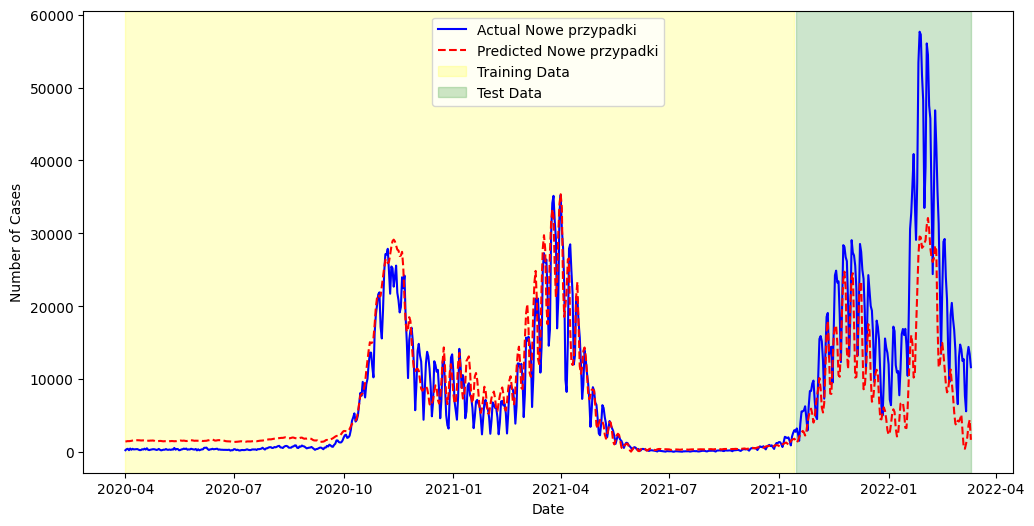

In [78]:
# Create sequences for the entire dataset for visualization purposes
def create_sequences_for_prediction(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        x = data[i:i+seq_length]
        xs.append(x)
    return np.array(xs)

data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Suma zgonów', 'Suma wyzdrowień']].values
x_all = create_sequences_for_prediction(data, seq_length)

# Convert to PyTorch tensors
x_all = torch.tensor(x_all, dtype=torch.float32)

# Use the model to generate predictions for the entire dataset
model.eval()
with torch.no_grad():
    predictions_full = []
    for i in range(len(x_all)):
        x_input = x_all[i:i+1]  # Get one sequence at a time
        y_input = torch.zeros_like(x_input)
        y_input[:, 1:, :] = x_input[:, :-1, :]
        y_input[:, 0, :] = x_input[:, 0, :]

        output = model(x_input, y_input)
        predictions_full.append(output[:, -1, :].numpy())

# Convert predictions to numpy array
predictions_full = np.vstack(predictions_full)

# Rescale the predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions_full)
y_rescaled = scaler.inverse_transform(data[seq_length-1:])

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Data'][seq_length-1:], y_rescaled[:, 0], label='Actual Nowe przypadki', color='blue')
plt.plot(df['Data'][seq_length-1:], predictions_rescaled[:, 0], label='Predicted Nowe przypadki', color='red', linestyle='dashed')

# Mark the training and test data range
train_range = range(seq_length-1, split_idx)
test_range = range(split_idx, len(df))

plt.axvspan(df['Data'].iloc[train_range.start], df['Data'].iloc[train_range.stop-1], alpha=0.2, color='yellow', label='Training Data')
plt.axvspan(df['Data'].iloc[test_range.start], df['Data'].iloc[test_range.stop-1], alpha=0.2, color='green', label='Test Data')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()